# Travelling salesman problem

This is short implementation of traveling salesman problem for the course Evolutionary Computing at ITMO University. Let us first import the required libraries. We use deap framwork for implementing the algorithm.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

from deap import creator, base, tools, algorithms
from IPython.display import display, clear_output

Let us also define funtion for generating the toolbox given dataset. We use two different types of crossovers between which we randomize.

In [28]:
def get_toolbox(data):
    '''data is n_cities x 2 numpy array'''
    trip_length = len(data)
    distance_matrix = np.zeros((trip_length, trip_length))
    for i in range(trip_length):
        for j in range(trip_length):
            distance_matrix[i][j] = np.sqrt((data[i][0] - data[j][0])**2 + (data[i][1] - data[j][1])**2)

    def distance(city_1, city_2):
        return distance_matrix[city_1][city_2]

    def fitness(individual):
        trip_length = 0
        for i in range(len(individual) - 1):
            trip_length += distance(individual[i], individual[i + 1])
        return (trip_length,)
    
    def mate(*args):
        if np.random.rand() < 0.5:
            tools.cxPartialyMatched(*args)
        else:
            tools.cxOrdered(*args)
    
    toolbox = base.Toolbox()
    toolbox.register("indices", random.sample, range(trip_length), trip_length)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", mate)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.01)
    toolbox.register("select", tools.selTournament, tournsize=10)
    toolbox.register("evaluate", fitness)
    
    return toolbox

In [3]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

We create a simple class with potential for multiple populations between which individuals can migrate. However, in the end that feature was not used as it proved out to not improve results.

In [4]:
class Evolution:
    def __init__(
            self,
            toolbox,
            population_size,
            iterations,
            n_mutants,
            n_matings,
            n_populations,
            migration_probability
        ):
        self.toolbox = toolbox
        self.population_size = population_size
        self.iterations = iterations
        self.n_mutants = n_mutants
        self.n_matings = n_matings
        self.n_populations = n_populations
        self.migration_probability = migration_probability
        self.populations = [self.toolbox.population(n=self.population_size) for  i in range(self.n_populations)]
    
    def _set_fittness(self, population):
        for individual in population:
            if not individual.fitness.valid:
                individual.fitness.values = self.toolbox.evaluate(individual)
    
    def _generate_offspring(self, population):
        offspring = []
        for i in range(self.n_matings):
            indexes = np.random.choice(range(len(population)), size=2, replace=False)
            child1, child2 = [self.toolbox.clone(population[index]) for index in indexes]
            self.toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
            offspring.append(child1)
            offspring.append(child2)
        return offspring

    def _generate_mutants(self, population):
        mutants = []
        for i in range(self.n_mutants):
            individual = population[np.random.randint(0, len(population))]
            mutant = self.toolbox.clone(individual)
            self.toolbox.mutate(mutant)
            del mutant.fitness.values
            mutants.append(mutant)
        return mutants
    
    def _mutate(self, population):
        for individual in population:
            if np.random.rand() < self.mutation_probability:
                toolbox.mutate(individual)
                del individual.fitness.values
    
    def _migrate(self, populations):
        if len(populations) == 1:
            return
        for i, population in enumerate(populations):
            if np.random.rand() < self.migration_probability:
                numbers = list(range(0, len(populations)))
                numbers.remove(i)
                target_i = random.choice(numbers)
                individual_index = np.random.randint(0, len(populations[i]))
                populations[target_i].append(populations[i][individual_index])
                del populations[i][individual_index]
                print(f"Migration occured from {i} to {target_i}")
    
    def _clone_population(self, population):
        cloned_population = []
        for individual in population:
            cloned_individual = self.toolbox.clone(individual)
            del cloned_individual.fitness.values
            cloned_population.append(cloned_individual)
        return cloned_population
    
    def _get_stats(self, populations):
        population_indexes = []
        population_fitnesses = []
        population_best_individuals = []
        for population in populations:
            fitnesses = [individual.fitness.values[0] for individual in population]
            min_index = np.argmin(fitnesses)
            population_fitnesses.append(fitnesses[min_index])
            population_indexes.append(min_index)
            population_best_individuals.append(population[min_index])
        min_population_index = np.argmin(population_fitnesses)
        return {
            'min_fitness': population_fitnesses[min_population_index],
            'best_individual': populations[min_population_index][population_indexes[min_population_index]],
            'best_population': min_population_index,
            'population_fitnesses': population_fitnesses,
            'population_best_individuals': population_best_individuals
        }
    
    def run(self, callback):
        for population in self.populations:
            self._set_fittness(population)
        #toolbox.clone(population[0])
        for i in range(self.iterations):
            self._migrate(self.populations)
            for j, population in enumerate(self.populations):
                mutants = self._generate_mutants(population)
                offspring = self._generate_offspring(population)
                self._set_fittness(offspring)
                self._set_fittness(mutants)
                population[:] = self.toolbox.select(offspring + mutants, len(population))
            stats = self._get_stats(self.populations)
            callback(stats, i)
        

Then we can run the algorithm with different datasets. Let first define the function for obtaining callback function given data. Output function will print best individuals of each population every 100 iterations.

In [20]:
def plot_individual(individual, data, axis):
    route = np.empty((len(individual), 2))
    for i, point in enumerate(individual):
        route[i] = data[individual[i]]
    axis.cla()
    axis.plot(route[:, 0], route[:, 1])
    axis.scatter(data[:, 0], data[:, 1])

def get_output_function(data, best_individuals):
    fig = plt.figure(figsize=(18, 18));
    axes = [fig.add_subplot(1, 1, i) for i in range(1, 1 + 1)]
    def output(stats, iteration):
        best_individuals.append(stats['best_individual'])
        if iteration % 100 == 100 - 1:
            clear_output(wait=True)
            for i, ax in enumerate(axes):
                individual = stats['population_best_individuals'][i]
                plot_individual(individual, data, ax)
            display(fig)
            print(f"Iteration: {iteration}")
            print(f"Min fitness: {stats['min_fitness']}")
            print(f"Best individual: {stats['best_individual']}")
            print(f"Best population: {stats['best_population']}")
            print(f"Population fitnesses: {stats['population_fitnesses']}")
    return output

We use four populations with each having 100 individuals. Best individuals are stored to the list for later use. We run the algorithm for 4000 iterations. Let us then run the algorithm for all the three datasets.

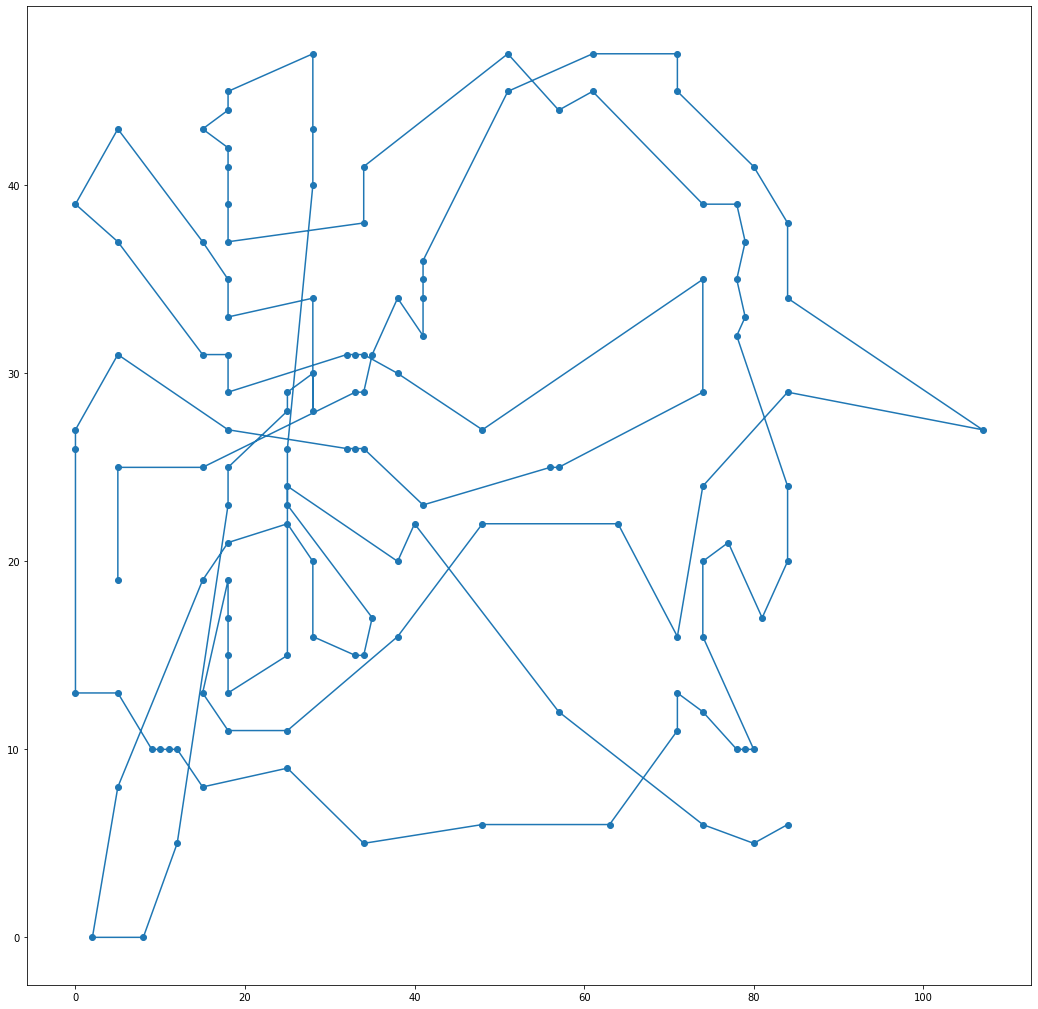

Iteration: 3999
Min fitness: 898.7664043506638
Best individual: [6, 7, 20, 65, 69, 75, 79, 82, 83, 84, 85, 89, 96, 103, 102, 121, 128, 127, 130, 126, 107, 101, 98, 86, 76, 44, 25, 18, 29, 28, 27, 26, 45, 49, 58, 59, 60, 43, 42, 23, 41, 40, 39, 38, 71, 72, 90, 94, 95, 110, 116, 119, 115, 118, 114, 125, 124, 123, 112, 106, 105, 120, 117, 113, 104, 100, 99, 97, 88, 73, 52, 24, 16, 15, 14, 13, 5, 0, 1, 2, 8, 33, 61, 64, 68, 81, 91, 93, 108, 109, 87, 78, 70, 66, 62, 34, 35, 21, 9, 3, 10, 22, 37, 36, 57, 55, 56, 51, 50, 32, 31, 17, 12, 4, 11, 19, 30, 46, 54, 53, 63, 67, 74, 47, 48, 77, 80, 92, 111, 122, 129]
Best population: 0
Population fitnesses: [898.7664043506638]


In [6]:
data131 =  np.loadtxt('xqf131.tsp')[:, 1:]
best_individuals131 = []
evolution131 = Evolution(
    toolbox=get_toolbox(data131),
    population_size = 100,
    iterations = 4000,
    n_mutants = 100,
    n_matings = 100,
    n_populations = 1,
    migration_probability = 0.0
)
evolution131.run(get_output_function(data131, best_individuals131))

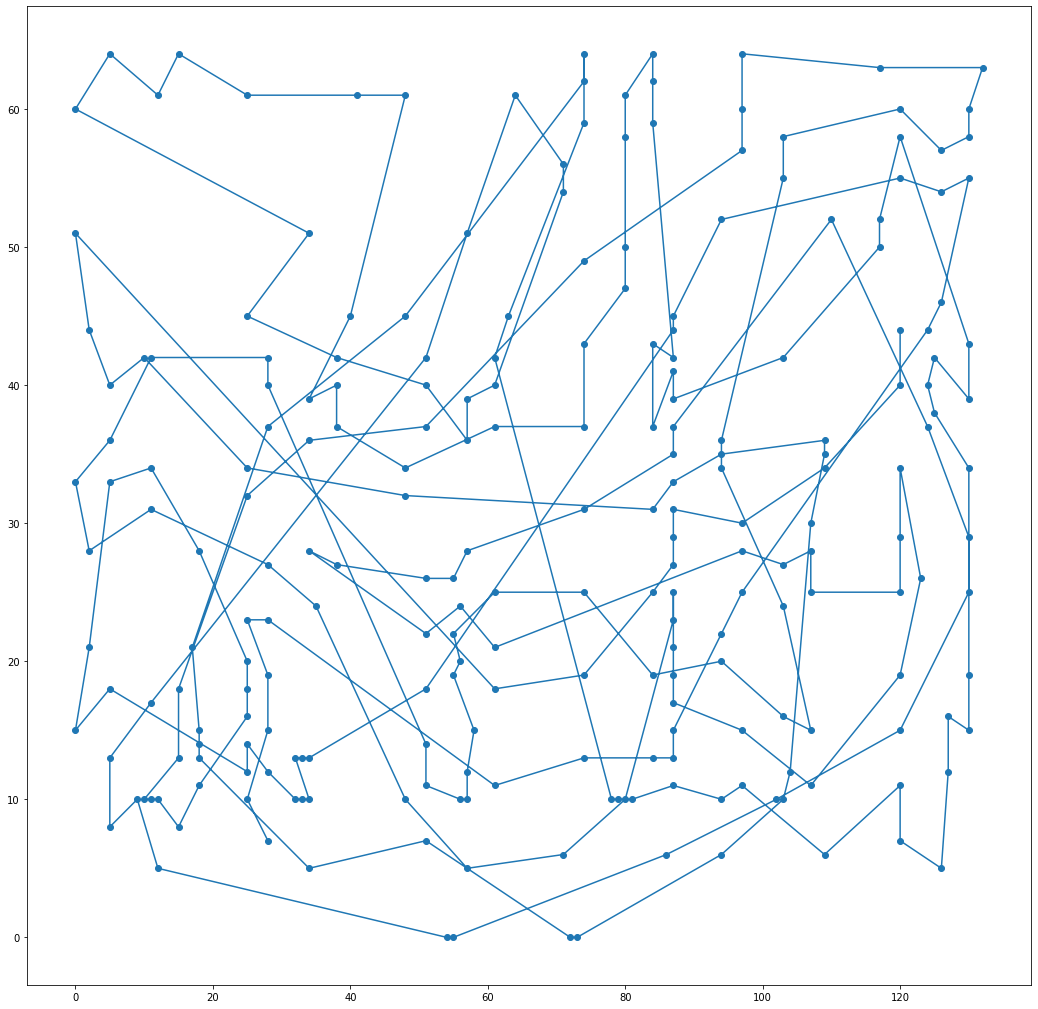

Iteration: 3999
Min fitness: 2346.8099348733713
Best individual: [209, 208, 194, 176, 155, 154, 153, 137, 118, 104, 2, 6, 11, 16, 43, 74, 138, 156, 168, 196, 195, 193, 188, 181, 171, 116, 115, 86, 64, 31, 32, 33, 29, 51, 76, 125, 126, 124, 110, 109, 127, 128, 134, 145, 164, 172, 197, 202, 213, 221, 224, 225, 226, 227, 230, 218, 216, 219, 231, 232, 211, 200, 199, 185, 159, 160, 139, 140, 161, 141, 142, 143, 133, 132, 131, 130, 122, 121, 107, 75, 68, 69, 63, 71, 77, 72, 45, 27, 24, 12, 3, 65, 44, 70, 84, 98, 99, 108, 112, 113, 111, 101, 85, 18, 7, 13, 14, 23, 87, 88, 144, 180, 203, 228, 229, 215, 198, 158, 157, 120, 97, 91, 82, 67, 61, 81, 94, 105, 175, 184, 192, 191, 205, 206, 207, 214, 204, 189, 173, 148, 149, 150, 152, 151, 129, 114, 100, 73, 66, 50, 19, 5, 1, 10, 21, 53, 52, 79, 78, 92, 95, 96, 102, 89, 93, 90, 106, 119, 136, 165, 182, 190, 183, 167, 169, 186, 187, 212, 223, 234, 235, 236, 201, 179, 178, 177, 123, 83, 62, 42, 26, 25, 15, 17, 22, 28, 30, 38, 39, 40, 34, 20, 9, 4, 0, 8

In [39]:
data237 =  np.loadtxt('xqg237.tsp')[:, 1:]
best_individuals237 = []
evolution237 = Evolution(
    toolbox=get_toolbox(data237),
    population_size = 100,
    iterations = 4000,
    n_mutants = 100,
    n_matings = 100,
    n_populations = 1,
    migration_probability = 0.000
)
evolution237.run(get_output_function(data237, best_individuals237))
plt.close()

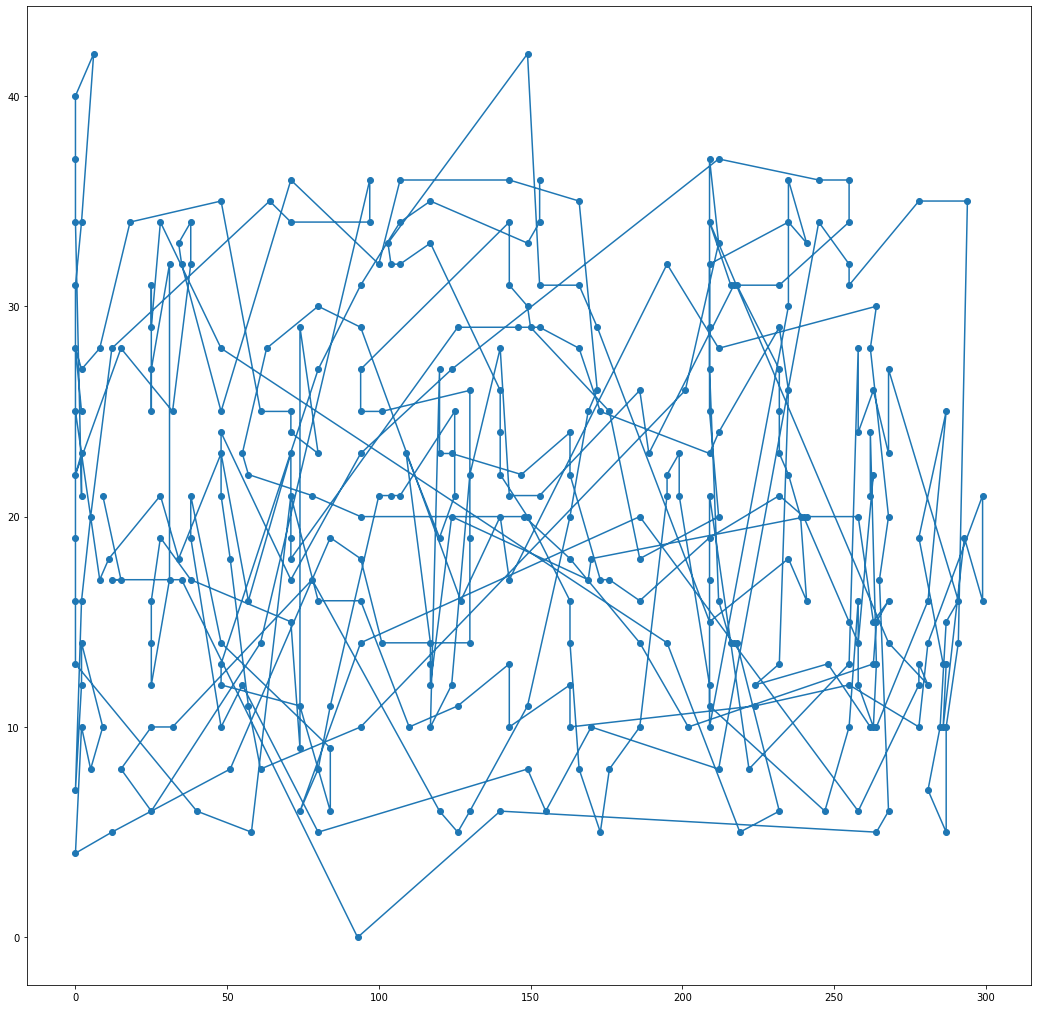

Iteration: 3999
Min fitness: 5279.929715682788
Best individual: [189, 188, 181, 142, 133, 121, 103, 64, 63, 95, 109, 110, 65, 58, 57, 62, 74, 105, 183, 190, 205, 250, 280, 289, 288, 324, 340, 337, 332, 336, 328, 329, 334, 338, 318, 317, 307, 296, 297, 286, 258, 236, 234, 231, 282, 284, 294, 292, 303, 309, 301, 300, 306, 293, 287, 276, 262, 235, 217, 212, 209, 197, 198, 176, 149, 144, 145, 137, 147, 159, 166, 171, 185, 220, 221, 254, 256, 265, 264, 263, 270, 275, 277, 269, 233, 208, 200, 187, 182, 128, 130, 132, 141, 165, 164, 163, 179, 194, 193, 202, 211, 214, 215, 223, 224, 227, 226, 232, 230, 272, 274, 279, 273, 241, 240, 238, 245, 218, 213, 184, 180, 172, 173, 119, 118, 127, 160, 158, 157, 126, 115, 108, 73, 31, 9, 12, 22, 26, 14, 13, 11, 15, 21, 30, 84, 93, 122, 123, 80, 44, 34, 36, 50, 99, 146, 155, 161, 178, 196, 204, 207, 201, 174, 134, 125, 94, 69, 55, 53, 60, 59, 51, 33, 3, 17, 16, 7, 8, 10, 23, 20, 6, 2, 1, 0, 61, 79, 89, 101, 114, 136, 153, 169, 168, 192, 191, 259, 285, 320,

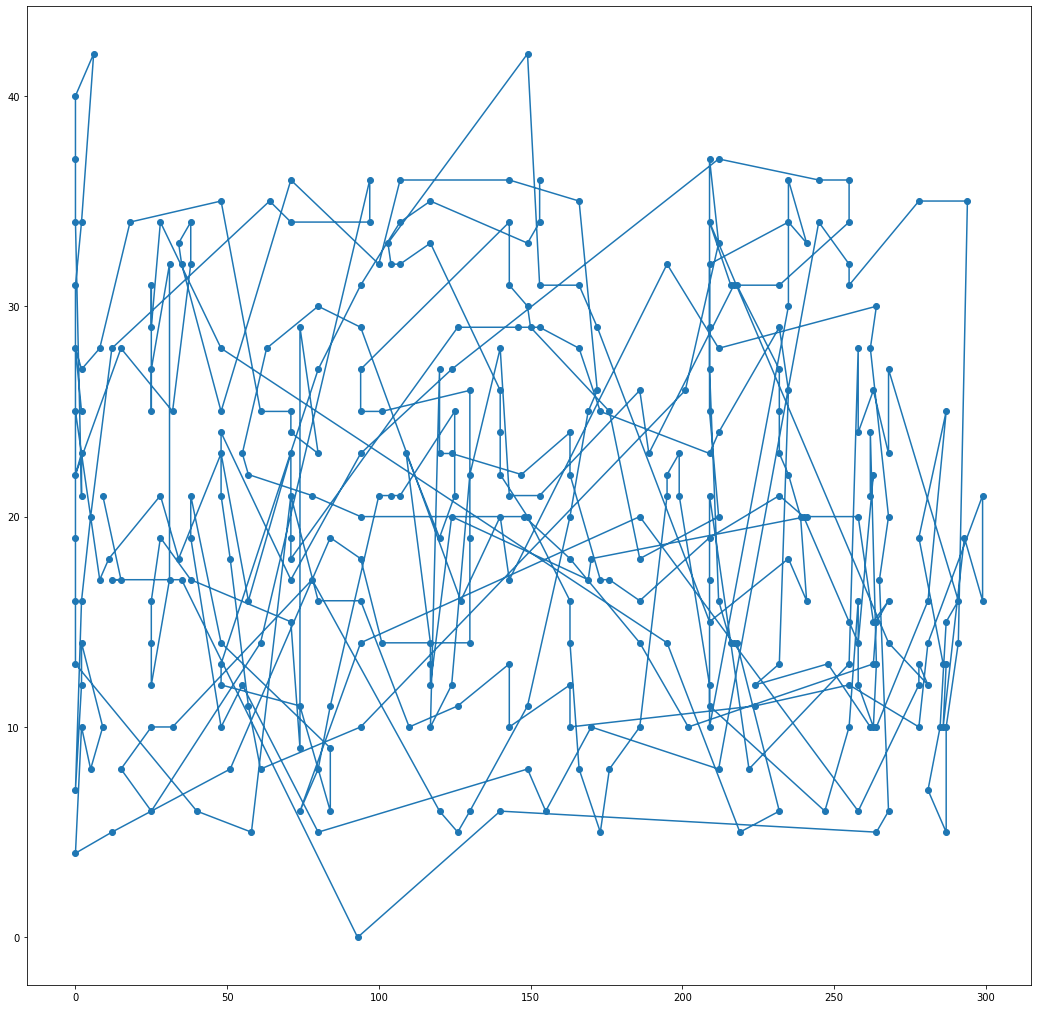

In [43]:
data343 =  np.loadtxt('pma343.tsp')[:, 1:]
best_individuals343 = []
evolution343 = Evolution(
    toolbox=get_toolbox(data343),
    population_size = 100,
    iterations = 4000,
    n_mutants = 100,
    n_matings = 100,
    n_populations = 1,
    migration_probability = 0.000
)
evolution343.run(get_output_function(data343, best_individuals343))

During computation phase we did not round the distances between cities. However, for final evaluation we want to do this. Let us compute now the final scores.

In [44]:
def evaluate(individual, data):
    trip_length = 0

    def distance(x1, x2):
        return np.round(np.sqrt((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2))

    for i in range(len(individual) - 1):
        trip_length += distance(data[individual[i]], data[individual[i + 1]])
    return (trip_length,)

print(f"Score for best solution to xqf131 dataset: {evaluate(best_individuals141[-1], data131)}")
print(f"Score for best solution to xqg237 dataset: {evaluate(best_individuals237[-1], data237)}")
print(f"Score for best solution to pma343 dataset: {evaluate(best_individuals343[-1], data343)}")

Score for best solution to xqf131 dataset: (896.0,)
Score for best solution to xqg237 dataset: (2340.0,)
Score for best solution to pma343 dataset: (5259.0,)


Best individual obtained for the dataset xqf131 had fittness of 896 (optimal is 564).

Best individual obtained for the dataset xqg237 had fittness of 2340 (optimal is 1019).

Best individual obtained for the dataset pma343 had fittness of 5259 (optimal is 1368).

Significantly better results could have been obtained by running the algorithms longer especially in the case of last two datasets.